<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

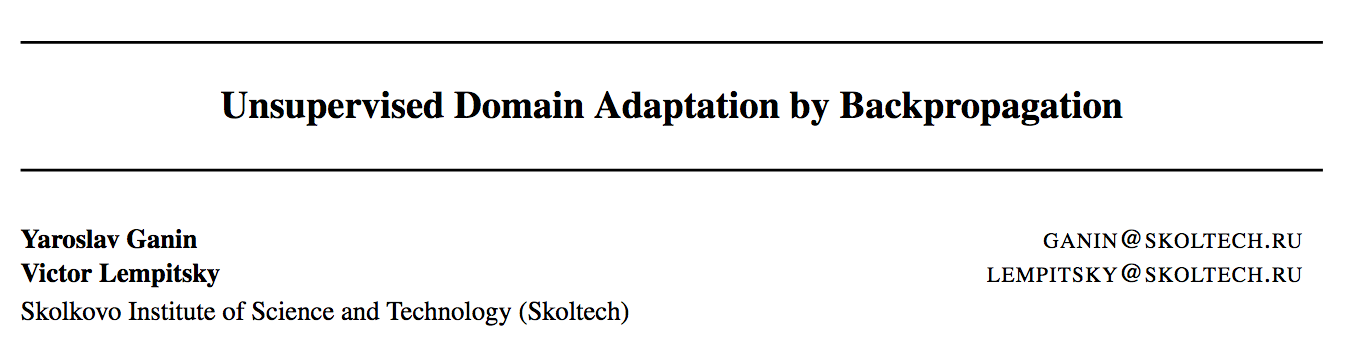

In [19]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/users/Etu8/21306668/.conda/envs/rdfia/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f', 'std', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [20]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

In [21]:
torch.__version__

'1.13.1+cu116'

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [22]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2023-12-29 13:29:04--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving proxy (proxy)... 132.227.118.143, 132.227.118.144
Connecting to proxy (proxy)|132.227.118.143|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2821 (2.8K) [text/plain]
Saving to: 'mnistm.py.3'

mnistm.py.3         100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-12-29 13:29:04 (61.9 MB/s) - 'mnistm.py.3' saved [2821/2821]



In [23]:
from mnistm import create_mnistm

create_mnistm()

Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [24]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [25]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x, # to replicate mnist from graylevel to rgb
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

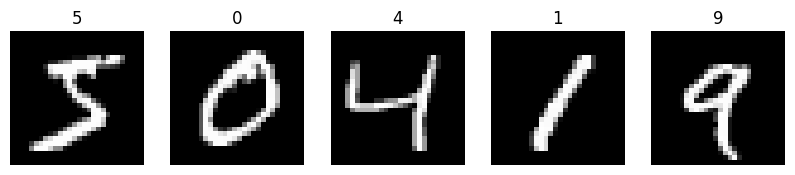

In [26]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [27]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

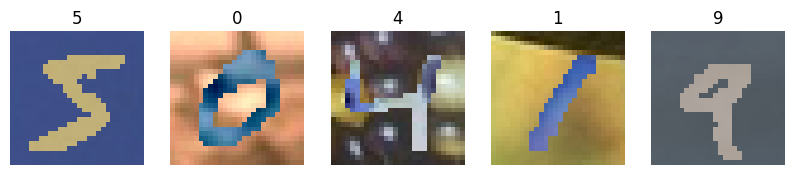

In [28]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

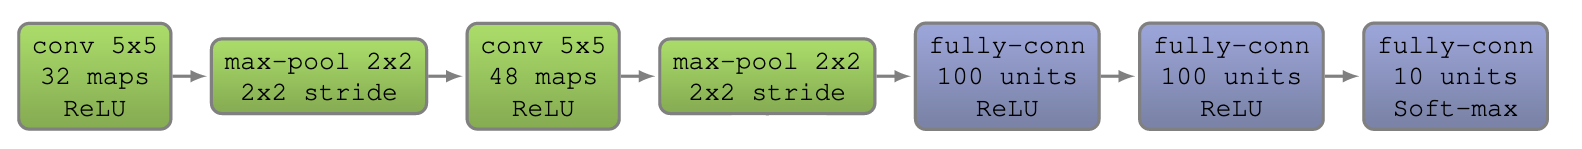

In [29]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [30]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
  )

    self.classif = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=48 * 4 * 4, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10)
    # no softmax because we use cross entropy loss
  )

  def forward(self, x):
    self.features = self.cnn(x)
    x = self.classif(self.features)
    return x


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [31]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [32]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.38445
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.06167
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.04347
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.03482
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.02951
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.02578
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.02296
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.02069
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.01888
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.01734
	Learning rate = 0.0016556002607617019
Test loss: 0.02813, test acc: 99.04


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [33]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.23689, test acc: 60.18


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

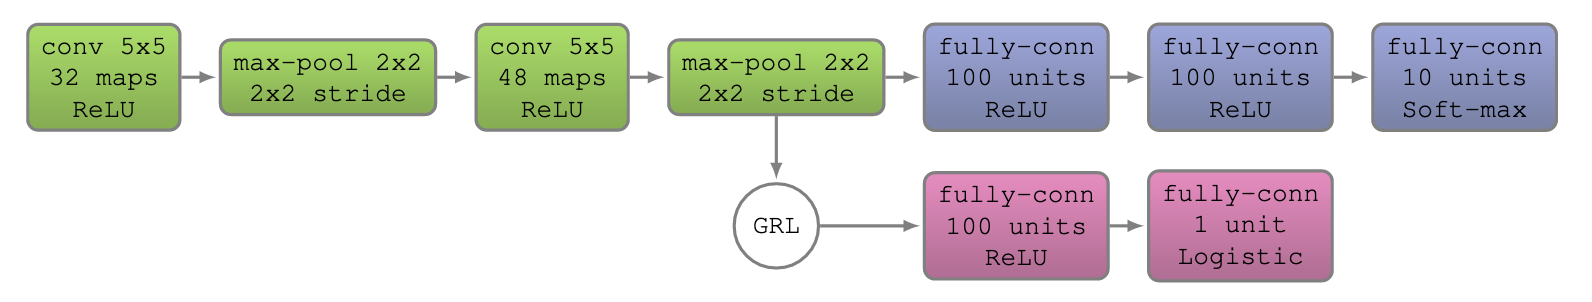

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [34]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = factor * grad

    return reversed_grad, None

In [35]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

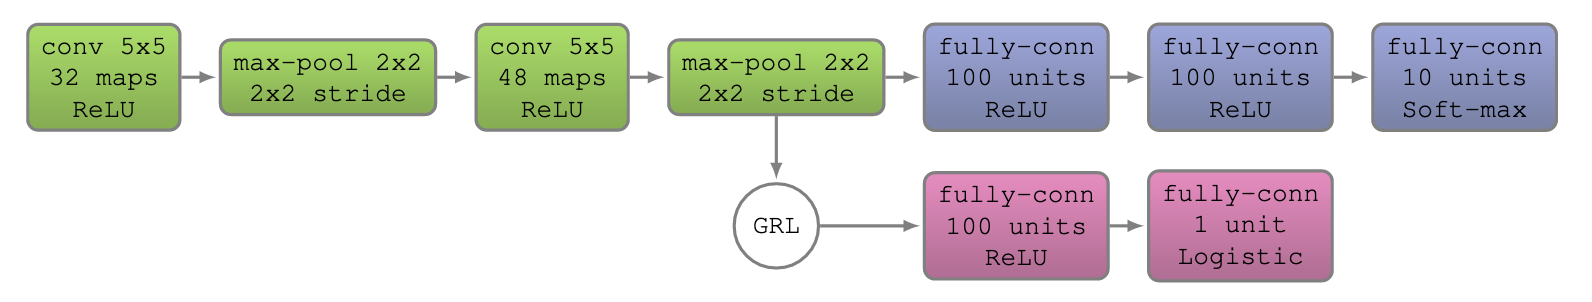

In [36]:
class DANN(nn.Module):
  def __init__(self, activation: str = "sigmoid"):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    # ReLU / Sigmoid
    nn.Sigmoid() if activation == "sigmoid" else nn.ReLU()
  )

    self.classif = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=48 * 4 * 4, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10),
    # no softmax because we use cross entropy loss

  )

    self.domain = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=48 * 4 * 4, out_features=100),

    nn.ReLU(),
    nn.Linear(in_features=100, out_features=1)
    # no softmax because we use binary cross entropy loss

  )

  def forward(self, x, factor=-1):
    self.features = self.cnn(x)
    # x.shape -> 128
    # 64 -> Gray 64 -> RGB
    class_pred = self.classif(self.features)
    features_r = GradientReversal.apply(self.features, factor)
    domain_pred = self.domain(features_r)

    return class_pred, domain_pred


In [37]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [38]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

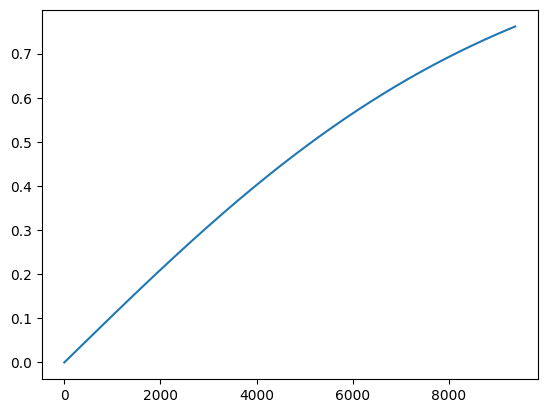

In [39]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

My comment:
From the main paper, "For loss functions, we set Ly and Ld to be the logistic regression loss and the binomial cross-entropy respectively."

In [40]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=0.3, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    batch_size = xs.shape[0] # 64

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt), dim=0)

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=-grl_factor)

    yhat_s, yhat_t = cls_logits.chunk(2, dim=0)

    domain_logits_labels = torch.cat((torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), dim=0).cuda()

    ce = nn.CrossEntropyLoss()  # For classification loss 
    ce = ce(yhat_s, ys)
    bce = nn.BCEWithLogitsLoss()  # For binary cross-entropy loss
    bce = bce(domain_logits, domain_logits_labels) # [64 -> 1, 64 -> 0]
    loss = ce + bce * 0.6
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0


Epoch 0, class loss: 1.38869, domain loss: 0.2386
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.24562, domain loss: 0.19192
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.15097, domain loss: 0.19027
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.11834, domain loss: 0.24398
GRL factor 0.197375320224904
Epoch 4, class loss: 0.10025, domain loss: 0.23972
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.08867, domain loss: 0.24284
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.08058, domain loss: 0.23382
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.07512, domain loss: 0.23667
GRL factor 0.379948962255225
Epoch 8, class loss: 0.07108, domain loss: 0.23573
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.06696, domain loss: 0.2332
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.06368, domain loss: 0.23103
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.06122, domain loss: 0.23067
GRL factor 0.5370495669980351
Epoch 12, class loss: 0.059

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [41]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [42]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

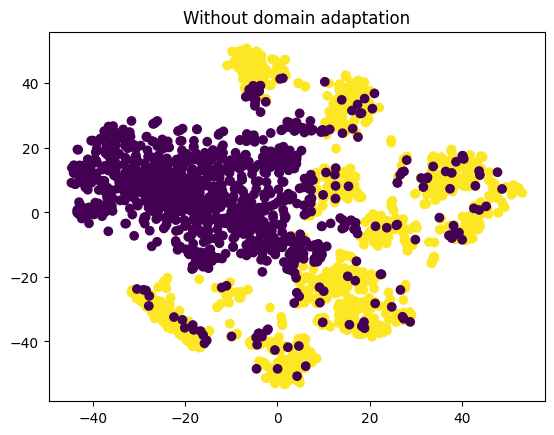

In [43]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

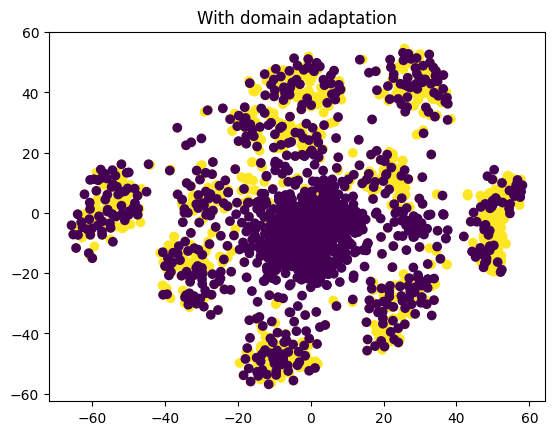

In [44]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

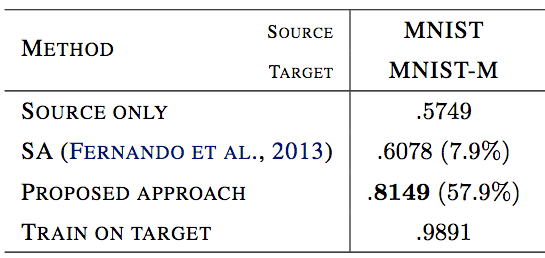

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

In [45]:
def train(epochs=20, lr=0.6, alpha=10, beta=0.75, activation='sigmoid'):
    dann = DANN(activation).cuda()

    optimizer = torch.optim.SGD(dann.parameters(), lr=lr, momentum=0.9)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda e: lr / (1 + alpha * e / epochs) ** beta
    )
    lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

    b = 0
    for epoch in range(epochs):
        cls_loss, domain_loss = 0., 0.
        grl_factor = lmbd(b)
        print(f"GRL factor {grl_factor}" )

        for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
            grl_factor = lmbd(b)
            b += 1

            batch_size = xs.shape[0] # 64

            xs, ys = xs.cuda(), ys.cuda()
            xt = xt.cuda()
            x = torch.cat((xs, xt), dim=0)

            optimizer.zero_grad()
            cls_logits, domain_logits = dann(x, factor=-grl_factor)

            yhat_s, yhat_t = cls_logits.chunk(2, dim=0)

            domain_logits_labels = torch.cat((torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), dim=0).cuda()

            ce = nn.CrossEntropyLoss()  # For classification loss TODO
            ce = ce(yhat_s, ys)
            bce = nn.BCEWithLogitsLoss()  # For binary cross-entropy loss TODO
            bce = bce(domain_logits, domain_logits_labels) # [64 -> 1, 64 -> 0]
            loss = ce + bce * 0.6
            loss.backward()
            optimizer.step()

            cls_loss += ce.item()
            domain_loss += bce.item()

            scheduler.step()
        cls_loss = round(cls_loss / len(source_train_loader), 5)
        domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
        print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')

    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
    print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
    print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

    source_emb = extract_emb(dann, source_train_loader)
    target_emb = extract_emb(dann, target_train_loader)

    print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

    indexes = np.random.permutation(len(source_emb))[:1000]

    emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
    domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

    print("Samples embeddings", emb.shape, domains.shape)

    tsne = TSNE(n_components=2)

    emb_2d = tsne.fit_transform(emb)
    print("Dimension reduced embeddings", emb_2d.shape)

    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
    plt.title("With domain adaptation")
    plt.show()
    

GRL factor 0.0


Epoch 0, class loss: 0.54161, domain loss: 0.15269
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.14318, domain loss: 0.21708
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.11283, domain loss: 0.21359
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.09802, domain loss: 0.23436
GRL factor 0.197375320224904
Epoch 4, class loss: 0.09037, domain loss: 0.26075
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.08575, domain loss: 0.26833
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.08156, domain loss: 0.27074
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.07943, domain loss: 0.27898
GRL factor 0.379948962255225
Epoch 8, class loss: 0.07737, domain loss: 0.27842
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.07515, domain loss: 0.26926
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.07286, domain loss: 0.25299
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.07139, domain loss: 0.25874
GRL factor 0.5370495669980351
Epoch 12, class loss: 0.0

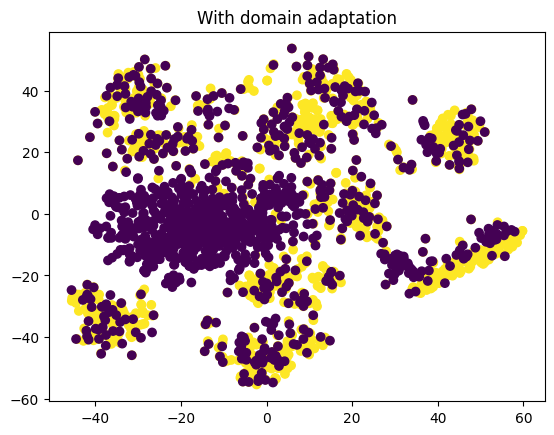

In [46]:
train(epochs=20, lr=0.5, alpha=10, beta=0.75, activation='sigmoid')

GRL factor 0.0
Epoch 0, class loss: 2.3003, domain loss: 0.34471
GRL factor 0.0996679946249559
Epoch 1, class loss: 2.29855, domain loss: 0.34395
GRL factor 0.197375320224904
Epoch 2, class loss: 2.29786, domain loss: 0.34364
GRL factor 0.2913126124515908
Epoch 3, class loss: 2.29728, domain loss: 0.34346
GRL factor 0.379948962255225
Epoch 4, class loss: 2.29687, domain loss: 0.34337
GRL factor 0.4621171572600098
Epoch 5, class loss: 2.29653, domain loss: 0.34333
GRL factor 0.5370495669980351
Epoch 6, class loss: 2.29624, domain loss: 0.34332
GRL factor 0.6043677771171634
Epoch 7, class loss: 2.29598, domain loss: 0.34335
GRL factor 0.6640367702678489
Epoch 8, class loss: 2.29574, domain loss: 0.34339
GRL factor 0.7162978701990246
Epoch 9, class loss: 2.29552, domain loss: 0.34345
[SOURCE] Class loss/acc: 2.29505 / 11.35%, Domain loss/acc: 0.67169 / 99.98%
[TARGET] Class loss/acc: 2.29987 / 11.35%, Domain loss/acc: 0.70204 / 3.55%
Original embeddings of source / target (60000, 768) (60

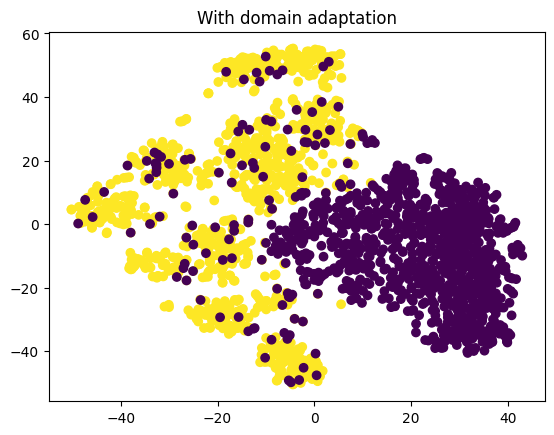

In [48]:
train(epochs=10, lr=0.1, alpha=10, beta=0.75, activation='sigmoid')

GRL factor 0.0
Epoch 0, class loss: 0.65577, domain loss: 0.19496
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.10637, domain loss: 0.21756
GRL factor 0.197375320224904
Epoch 2, class loss: 0.0778, domain loss: 0.23452
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.06592, domain loss: 0.22543
GRL factor 0.379948962255225
Epoch 4, class loss: 0.05816, domain loss: 0.21638
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.05526, domain loss: 0.22178
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.05387, domain loss: 0.22566
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.05326, domain loss: 0.23374
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.05188, domain loss: 0.23443
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.05345, domain loss: 0.24315
[SOURCE] Class loss/acc: 0.05256 / 98.47%, Domain loss/acc: 0.44261 / 85.43%
[TARGET] Class loss/acc: 1.39567 / 67.35%, Domain loss/acc: 0.54522 / 65.28%
Original embeddings of source / target (60000, 768) (6

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


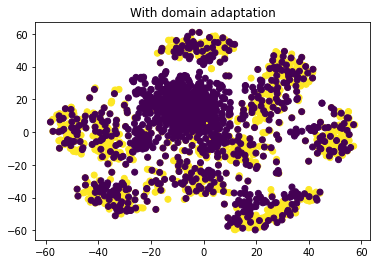

In [ ]:
train(epochs=10, lr=1.0, alpha=20, beta=0.75, activation='sigmoid')

GRL factor 0.0
Epoch 0, class loss: 0.33835, domain loss: 0.13308
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.06503, domain loss: 0.10479
GRL factor 0.197375320224904
Epoch 2, class loss: 0.04535, domain loss: 0.11618
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.03802, domain loss: 0.11445
GRL factor 0.379948962255225
Epoch 4, class loss: 0.03483, domain loss: 0.11589
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.03436, domain loss: 0.12064
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.03432, domain loss: 0.12405
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.03374, domain loss: 0.13209
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.03521, domain loss: 0.13776
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.04336, domain loss: 0.16403
[SOURCE] Class loss/acc: 0.04393 / 98.73%, Domain loss/acc: 0.26748 / 91.16%
[TARGET] Class loss/acc: 1.03221 / 66.59%, Domain loss/acc: 0.4098 / 80.47%
Original embeddings of source / target (60000, 768) (6

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


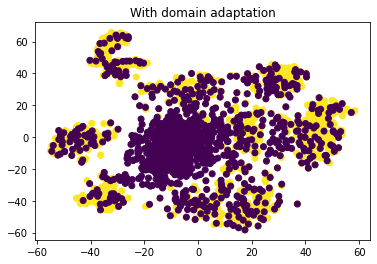

In [ ]:
train(epochs=10, lr=0.5, alpha=10, beta=0.75, activation='relu')

GRL factor 0.0
Epoch 0, class loss: 0.3275, domain loss: 0.12968
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.06162, domain loss: 0.08767
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.04293, domain loss: 0.10989
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.03368, domain loss: 0.10699
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02844, domain loss: 0.10006
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.02504, domain loss: 0.10099
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.023, domain loss: 0.10346
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.02275, domain loss: 0.10868
GRL factor 0.379948962255225
Epoch 8, class loss: 0.02262, domain loss: 0.11663
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.02276, domain loss: 0.12099
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.02574, domain loss: 0.1328
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.02692, domain loss: 0.1468
GRL factor 0.5370495669980351
Epoch 12, class

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


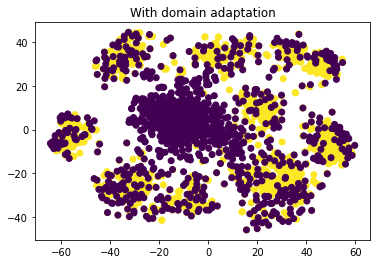

In [ ]:
train(epochs=20, lr=0.5, alpha=10, beta=0.75, activation='relu')

GRL factor 0.0
Epoch 0, class loss: 0.79443, domain loss: 0.10175
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.15963, domain loss: 0.04742
GRL factor 0.197375320224904
Epoch 2, class loss: 0.12127, domain loss: 0.18461
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.09912, domain loss: 0.19348
GRL factor 0.379948962255225
Epoch 4, class loss: 0.08672, domain loss: 0.16527
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.0791, domain loss: 0.15415
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.0745, domain loss: 0.15232
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.07117, domain loss: 0.15387
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.06878, domain loss: 0.15262
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.06742, domain loss: 0.15372
[SOURCE] Class loss/acc: 0.06089 / 98.09%, Domain loss/acc: 0.16627 / 97.36%
[TARGET] Class loss/acc: 1.47168 / 56.97%, Domain loss/acc: 0.44539 / 77.44%
Original embeddings of source / target (60000, 768) (60

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


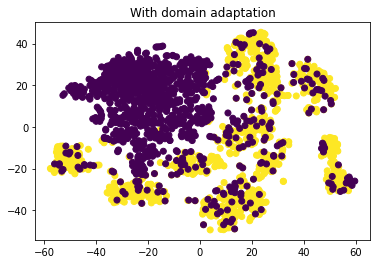

In [ ]:
train(epochs=10, lr=0.1, alpha=10, beta=0.75, activation='relu')

GRL factor 0.0
Epoch 0, class loss: 0.23492, domain loss: 0.12275
GRL factor 0.0996679946249559
Epoch 1, class loss: 0.04447, domain loss: 0.0974
GRL factor 0.197375320224904
Epoch 2, class loss: 0.03256, domain loss: 0.12493
GRL factor 0.2913126124515908
Epoch 3, class loss: 0.03092, domain loss: 0.13111
GRL factor 0.379948962255225
Epoch 4, class loss: 0.03444, domain loss: 0.14257
GRL factor 0.4621171572600098
Epoch 5, class loss: 0.03672, domain loss: 0.16166
GRL factor 0.5370495669980351
Epoch 6, class loss: 0.04177, domain loss: 0.18225
GRL factor 0.6043677771171634
Epoch 7, class loss: 0.03508, domain loss: 0.18058
GRL factor 0.6640367702678489
Epoch 8, class loss: 0.05802, domain loss: 0.24949
GRL factor 0.7162978701990246
Epoch 9, class loss: 0.06272, domain loss: 0.26229
[SOURCE] Class loss/acc: 0.06096 / 98.03%, Domain loss/acc: 0.45988 / 76.39%
[TARGET] Class loss/acc: 1.48006 / 57.71%, Domain loss/acc: 0.44218 / 80.99%
Original embeddings of source / target (60000, 768) (6

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension reduced embeddings (2000, 2)


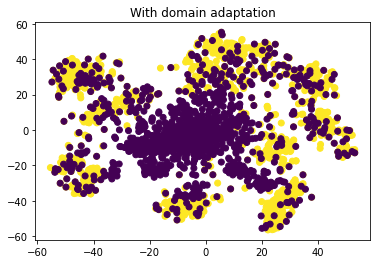

In [ ]:
train(epochs=10, lr=1.0, alpha=20, beta=0.75, activation='relu')

---

BEST RESULTS

we obtain the best results with these changes frfom the baseline:
- 50 epochs
- lr increased (0.1 intead of 0.01)
- alpha increased (20 instead of 10)
- standardization with sigmoid

In [52]:
def train(epochs=20, lr=0.6, alpha=10, beta=0.75, activation='sigmoid'):
    dann = DANN(activation).cuda()

    optimizer = torch.optim.SGD(dann.parameters(), lr=lr, momentum=0.9)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda e: lr / (1 + alpha * e / epochs) ** beta
    )
    lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

    b = 0
    for epoch in range(epochs):
        cls_loss, domain_loss = 0., 0.
        grl_factor = lmbd(b)
        print(f"GRL factor {grl_factor}" )

        for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
            grl_factor = lmbd(b)
            b += 1

            batch_size = xs.shape[0] # 64

            xs, ys = xs.cuda(), ys.cuda()
            xt = xt.cuda()
            x = torch.cat((xs, xt), dim=0)

            optimizer.zero_grad()
            cls_logits, domain_logits = dann(x, factor=-grl_factor)

            yhat_s, yhat_t = cls_logits.chunk(2, dim=0)

            domain_logits_labels = torch.cat((torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), dim=0).cuda()

            ce = nn.CrossEntropyLoss()  # For classification loss
            ce = ce(yhat_s, ys)
            bce = nn.BCEWithLogitsLoss()  # For binary cross-entropy loss 
            bce = bce(domain_logits, domain_logits_labels) # [64 -> 1, 64 -> 0]
            loss = ce + bce * 0.6
            loss.backward()
            optimizer.step()

            cls_loss += ce.item()
            domain_loss += bce.item()

        scheduler.step()
        cls_loss = round(cls_loss / len(source_train_loader), 5)
        domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
        print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')

    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
    print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

    c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
    print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

    source_emb = extract_emb(dann, source_train_loader)
    target_emb = extract_emb(dann, target_train_loader)

    print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

    indexes = np.random.permutation(len(source_emb))[:1000]

    emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
    domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

    print("Samples embeddings", emb.shape, domains.shape)

    tsne = TSNE(n_components=2)

    emb_2d = tsne.fit_transform(emb)
    print("Dimension reduced embeddings", emb_2d.shape)

    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
    plt.title("With domain adaptation")
    plt.show()
    

GRL factor 0.0


Epoch 0, class loss: 0.61236, domain loss: 0.10863
GRL factor 0.01999733375993107
Epoch 1, class loss: 0.11365, domain loss: 0.11332
GRL factor 0.039978680311163695
Epoch 2, class loss: 0.07625, domain loss: 0.16617
GRL factor 0.05992810352914346
Epoch 3, class loss: 0.06296, domain loss: 0.20248
GRL factor 0.07982976911113138
Epoch 4, class loss: 0.05405, domain loss: 0.23518
GRL factor 0.0996679946249559
Epoch 5, class loss: 0.04737, domain loss: 0.23638
GRL factor 0.11942729853438583
Epoch 6, class loss: 0.0407, domain loss: 0.22463
GRL factor 0.1390924478784581
Epoch 7, class loss: 0.03631, domain loss: 0.21109
GRL factor 0.158648504297499
Epoch 8, class loss: 0.03296, domain loss: 0.19889
GRL factor 0.17808086811733026
Epoch 9, class loss: 0.03028, domain loss: 0.18997
GRL factor 0.197375320224904
Epoch 10, class loss: 0.02826, domain loss: 0.18814
GRL factor 0.21651806149302866
Epoch 11, class loss: 0.02622, domain loss: 0.18667
GRL factor 0.23549574953849794
Epoch 12, class loss

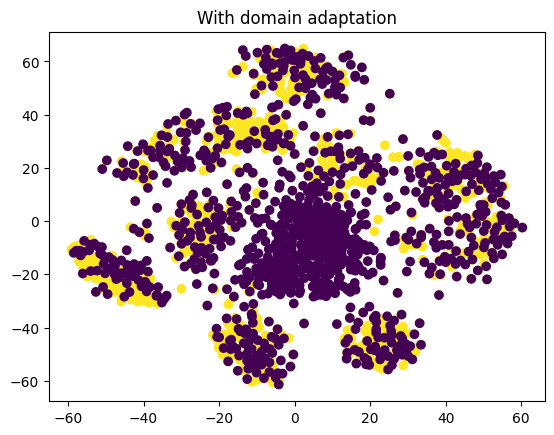

In [53]:
train(epochs=50, lr=0.1, alpha=20, beta=0.75, activation='sigmoid') 